## Preamble

In [1]:
%load_ext autoreload
%autoreload 0

In [2]:
%autoreload

In [3]:
import sys
sys.path.append('/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts')

In [4]:
import xarray as xr
import sqlite3
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import torch
import pyro
import scipy as sp

import lib.plot
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from lib.pandas_util import idxwhere


import sfacts as sf

# from lib.project_style import color_palette, major_allele_frequency_bins
# from lib.project_data import metagenotype_db_to_xarray
# from lib.plot import ordination_plot, mds_ordination, nmds_ordination
# import lib.plot
# from lib.plot import construct_ordered_pallete
# from lib.pandas_util import idxwhere

## Load Data

In [5]:
fit = sf.data.World.load('data/zshi.sp-102506.metagenotype.filt-poly05-cvrg25.fit-sfacts44-s200-g5000-seed0.refit-sfacts41-g10000-seed0.world.nc')
fit = sf.World(fit.data.drop("species_id"))
fit.data['position'] = fit.data.position.astype(int)
print(fit.sizes)


cull_threshold = 0.05

fit_communities = fit.communities.mlift('sel', strain=fit.communities.max("sample") > cull_threshold)
print((1 - fit_communities.sum("strain")).max())
fit_communities = sf.Communities(fit_communities.data / fit_communities.sum("strain"))
fit_genotypes = fit.genotypes.mlift('sel', strain=fit_communities.strain)

fit = sf.World.from_combined(fit_communities, fit_genotypes, fit.metagenotypes)
print(fit.sizes)

Frozen(SortedKeysDict({'strain': 200, 'sample': 9232, 'position': 75942, 'allele': 2}))
<xarray.DataArray 'communities' ()>
array(0.00055164, dtype=float32)
Frozen(SortedKeysDict({'strain': 123, 'sample': 9232, 'position': 75942, 'allele': 2}))


In [6]:
ref = sf.data.Metagenotypes.load('data/gtprodb.sp-102506.genotype.nc').mlift('sel', position=fit.position).to_estimated_genotypes(pseudo=0)
ref.sizes

Frozen({'strain': 1000, 'position': 75942})

/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)


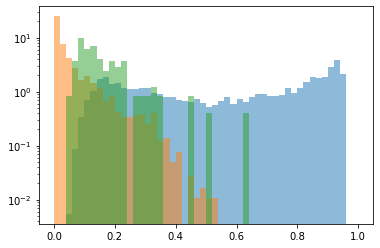

In [7]:
bins = np.linspace(0, 1, num=51)

plt.hist(fit.metagenotypes.to_estimated_genotypes(pseudo=1e-10).entropy(), bins=bins, alpha=0.5, density=True)
plt.hist(fit.metagenotypes.entropy(), bins=bins, alpha=0.5, density=True)
plt.hist(fit.genotypes.entropy(), bins=bins, alpha=0.5, density=True)
# plt.hist(ref.entropy(), bins=bins, alpha=0.5, density=True)

plt.yscale('log')
None

In [8]:
rank_abundance = fit.communities.to_series().groupby(level='sample').apply(lambda x: pd.Series(sorted(x)[::-1])).rename_axis(['sample', 'rank'])
cum_rank_abundance = rank_abundance.unstack('rank').sort_index('columns').cumsum(1).stack()
rev_cum_rank_abundance = rank_abundance.unstack('rank').sort_index('columns', ascending=False).cumsum(1).stack()

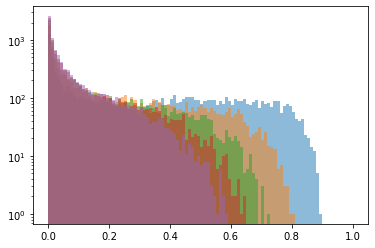

In [9]:
bins = np.linspace(0, 1, num=101)
for rank in range(5):
    plt.hist(rev_cum_rank_abundance.xs(rank + 1, level='rank'), bins=bins, alpha=0.5)
plt.yscale('log')

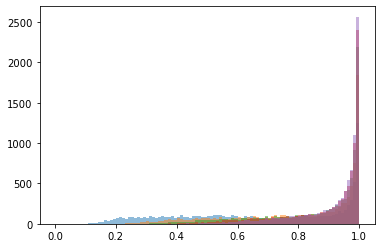

In [10]:
bins = np.linspace(0, 1, num=101)
for rank in range(5):
    plt.hist(cum_rank_abundance.xs(rank, level='rank'), bins=bins, alpha=0.5)

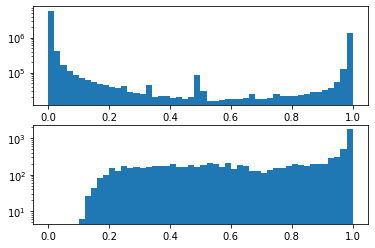

In [11]:
bins = np.linspace(0, 1, num=51)

fig, axs = plt.subplots(2)
axs[0].hist(fit.genotypes.values.flatten(), bins=bins)
axs[1].hist(fit.communities.max("strain").values.flatten(), bins=bins)

for ax in axs:
    pass
    ax.set_yscale('log')
None

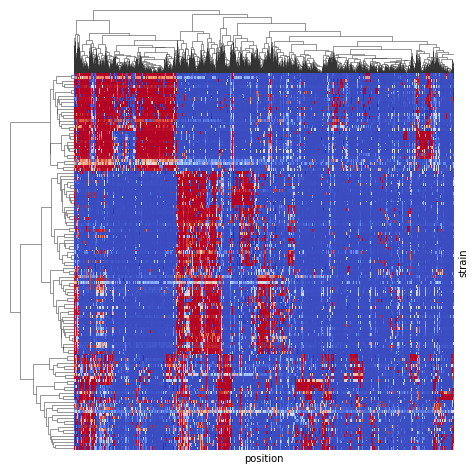

In [12]:
sf.plot.plot_genotype(fit.random_sample(position=5000), scaley=5e-2, scalex=1e-3, yticklabels=0)

/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)


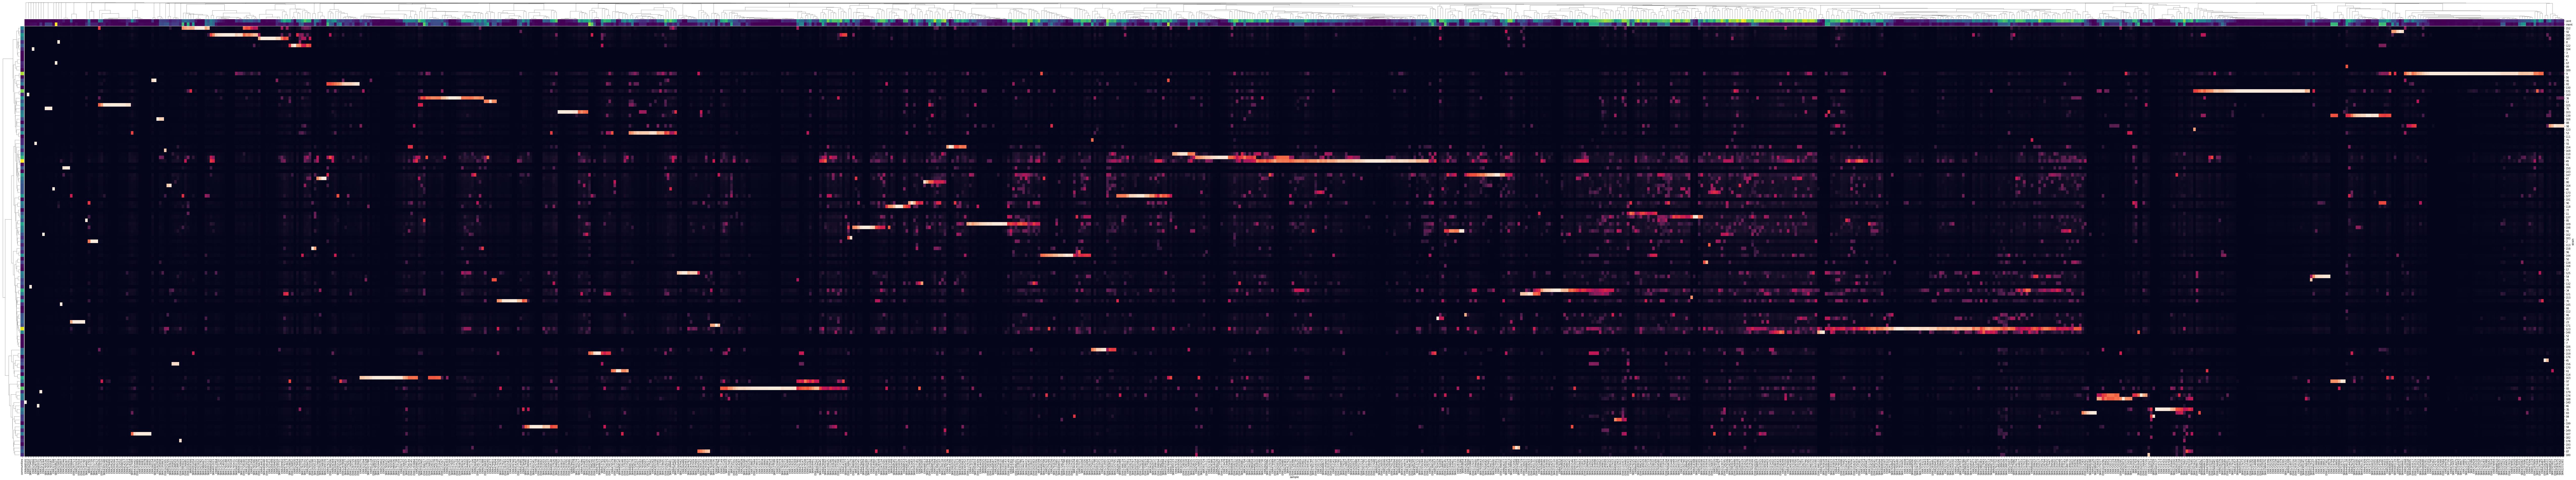

In [13]:
sf.plot.plot_community(
    fit.random_sample(sample=1000),
    col_colors_func=lambda w: xr.Dataset(dict(
        cent=w.communities.entropy("sample"),
        ment=w.metagenotypes.entropy("sample"),
    )),
    row_linkage_func=lambda w: w.genotypes.linkage("strain"),
#     yticklabels=0
)

In [14]:
genotype_entropy_thresh = 0.30

fit_genotypes_filt = fit.genotypes.mlift('sel', strain=fit.genotypes.entropy() < genotype_entropy_thresh)
fit_genotypes_highent = fit.genotypes.mlift('sel', strain=fit.genotypes.entropy() > genotype_entropy_thresh)

fit_genotypes_filt.sizes, fit_genotypes_highent.sizes

(Frozen({'strain': 112, 'position': 75942}),
 Frozen({'strain': 11, 'position': 75942}))

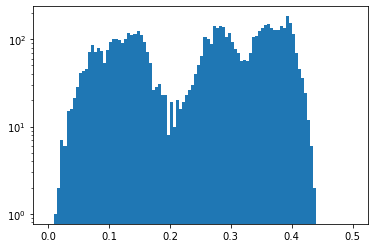

In [15]:
plt.hist(squareform(fit_genotypes_filt.pdist()), bins=np.linspace(0, 0.5, num=101))
plt.yscale('log')
None

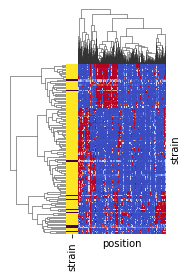

In [16]:
g = sf.data.Genotypes.concat(dict(
    bad=fit_genotypes_highent,
    good=fit_genotypes_filt
), dim='strain')


sf.plot.plot_genotype(g.random_sample(position=1000), row_colors_func=lambda w: w.strain.str.startswith('good'), scaley=2e-2, scalex=1e-3, yticklabels=0)

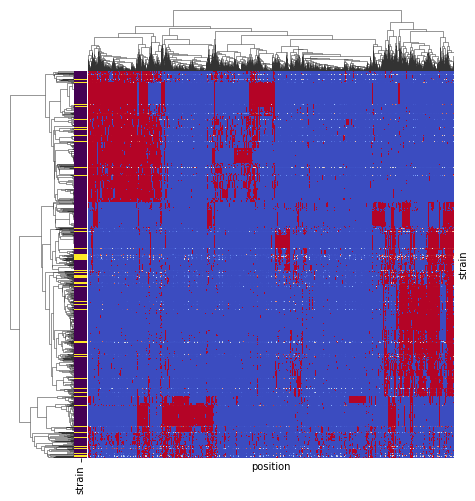

In [17]:
g = sf.data.Genotypes.concat(dict(
    ref=ref,
    fit=fit_genotypes_filt,
), dim='strain')


sf.plot.plot_genotype(g.random_sample(position=5000), row_colors_func=lambda w: w.strain.str.startswith('fit'), scaley=5e-3, scalex=1e-3, yticklabels=0)

In [18]:
from scipy.spatial.distance import pdist, squareform

_dist = squareform(pdist(g.discretized().values, metric='hamming'))
_dist = pd.DataFrame(_dist, index=g.strain, columns=g.strain)
fit_to_ref_dist = _dist.loc[lambda x: x.index.str.startswith('ref_'), lambda x: x.index.str.startswith('fit_')]

min_fit_to_ref_dist = fit_to_ref_dist.min(axis=0)
min_ref_to_fit_dist = fit_to_ref_dist.min(axis=1)

In [19]:
# Taken from https://gist.github.com/peterk87/b203f62a71d7f4fb273139b219af5e81

from typing import List

def _scipy_tree_to_newick_list(node: sp.cluster.hierarchy.ClusterNode, newick: List[str], parentdist: float, leaf_names: List[str]) -> List[str]:
    """Construct Newick tree from SciPy hierarchical clustering ClusterNode

    This is a recursive function to help build a Newick output string from a scipy.cluster.hierarchy.to_tree input with
    user specified leaf node names.

    Notes:
        This function is meant to be used with `to_newick`

    Args:
        node (scipy.cluster.hierarchy.ClusterNode): Root node is output of scipy.cluster.hierarchy.to_tree from hierarchical clustering linkage matrix
        parentdist (float): Distance of parent node of `node`
        newick (list of string): Newick string output accumulator list which needs to be reversed and concatenated (i.e. `''.join(newick)`) for final output
        leaf_names (list of string): Leaf node names

    Returns:
        (list of string): Returns `newick` list of Newick output strings
    """
    if node.is_leaf():
        return newick + [f'{leaf_names[node.id]}:{parentdist - node.dist}']

    if len(newick) > 0:
        newick.append(f'):{parentdist - node.dist}')
    else:
        newick.append(');')
    newick = _scipy_tree_to_newick_list(node.get_left(), newick, node.dist, leaf_names)
    newick.append(',')
    newick = _scipy_tree_to_newick_list(node.get_right(), newick, node.dist, leaf_names)
    newick.append('(')
    return newick


def to_newick(tree: sp.cluster.hierarchy.ClusterNode, leaf_names: List[str]) -> str:
    """Newick tree output string from SciPy hierarchical clustering tree

    Convert a SciPy ClusterNode tree to a Newick format string.
    Use scipy.cluster.hierarchy.to_tree on a hierarchical clustering linkage matrix to create the root ClusterNode for the `tree` input of this function.

    Args:
        tree (scipy.cluster.hierarchy.ClusterNode): Output of scipy.cluster.hierarchy.to_tree from hierarchical clustering linkage matrix
        leaf_names (list of string): Leaf node names

    Returns:
        (string): Newick output string
    """
    newick_list = _scipy_tree_to_newick_list(tree, [], tree.dist, leaf_names)
    return ''.join(newick_list[::-1])

In [20]:
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree
from io import StringIO
from Bio import Phylo
from copy import deepcopy

tree = Phylo.read(StringIO(to_newick(to_tree(linkage(squareform(_dist), method='average')), leaf_names=_dist.columns)), format='newick')

def prune_all_but(tree, names):
    tree = deepcopy(tree)
    all_leaves = tree.get_terminals()
    prune_list = []
    for leaf in all_leaves:
        prune_list += [leaf.name]
    for name in names:
        prune_list.remove(name)
    for name in prune_list:
        tree.prune(name)
    return tree

total_length = tree.total_branch_length()
fit_length = prune_all_but(tree, idxwhere(_dist.index.to_series().str.startswith('fit_'))).total_branch_length()
ref_length = prune_all_but(tree, idxwhere(_dist.index.to_series().str.startswith('ref_'))).total_branch_length()
fit_only = total_length - ref_length
ref_only = total_length - fit_length
shared_length = total_length - (fit_only + ref_only)

print(total_length, fit_length, ref_length, fit_only, ref_only, shared_length, fit_only / total_length, ref_only / total_length, shared_length / total_length)

34.800514056603774 13.94113697846525 25.95657827296768 8.843935783636095 20.85937707813852 5.097201194829157 0.25413233175956096 0.5993985331426513 0.14646913509778767


In [21]:
_dist2 = g.pdist()
tree2 = Phylo.read(StringIO(to_newick(to_tree(linkage(squareform(_dist2), method='average')), leaf_names=_dist.columns)), format='newick')
total_length = tree2.total_branch_length()
fit_length = prune_all_but(tree2, idxwhere(_dist2.index.to_series().str.startswith('fit_'))).total_branch_length()
ref_length = prune_all_but(tree2, idxwhere(_dist2.index.to_series().str.startswith('ref_'))).total_branch_length()
fit_only = total_length - ref_length
ref_only = total_length - fit_length
shared_length = total_length - (fit_only + ref_only)

print(total_length, fit_length, ref_length, fit_only, ref_only, shared_length, fit_only / total_length, ref_only / total_length, shared_length / total_length)

30.996597700607268 11.65246429672874 25.330160055442388 5.66643764516488 19.34413340387853 5.986026651563858 0.18280837464473937 0.624072796334662 0.1931188290205987


In [25]:
def all_taxa_names(tree):
    out = []
    for t in tree.get_terminals():
        out.append(t.name)
    return out

In [26]:
def tree_branch_length_fractions(tree, taxaA):
    taxaA = set(taxaA)
    taxaB = set(all_taxa_names(tree)) - taxaA
    total_length = tree.total_branch_length()
    lengthA = prune_all_but(tree, taxaA).total_branch_length()
    lengthB = prune_all_but(tree, taxaB).total_branch_length()
    onlyA = total_length - lengthB
    onlyB = total_length - lengthA
    return pd.Series(dict(total=total_length, onlyA=onlyA, onlyB=onlyB, shared=total_length - (onlyA + onlyB)))

tree_branch_length_fractions(tree2, idxwhere(_dist2.index.to_series().str.startswith('fit_')))

total     30.996598
onlyA      5.666438
onlyB     19.344133
shared     5.986027
dtype: float64

In [27]:
from tqdm import tqdm

def tree_branch_length_fractions_permutation_test(tree, taxa, n=1, progress=False):
    observed = tree_branch_length_fractions(tree, taxa)
    ntaxa = len(taxa)
    perm = []
    for i in tqdm(range(n), disable=(not progress)):
        perm_taxa = np.random.choice(all_taxa_names(tree), ntaxa, replace=False)
        perm.append(tree_branch_length_fractions(tree, perm_taxa))
    return observed, pd.DataFrame(perm)
    
observed, perm = tree_branch_length_fractions_permutation_test(tree, idxwhere(_dist.index.to_series().str.startswith('fit_')), n=10, progress=True)

100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


In [28]:
observed, perm

(total     34.800514
 onlyA      8.843936
 onlyB     20.859377
 shared     5.097201
 dtype: float64,
        total     onlyA      onlyB    shared
 0  34.800514  2.225084  26.500708  6.074722
 1  34.800514  2.095904  26.403431  6.301179
 2  34.800514  2.591634  25.665997  6.542883
 3  34.800514  1.733862  26.556033  6.510620
 4  34.800514  2.199805  26.079093  6.521616
 5  34.800514  1.978313  26.260444  6.561758
 6  34.800514  2.077827  26.362825  6.359862
 7  34.800514  1.732639  26.341942  6.725933
 8  34.800514  1.924258  26.048058  6.828198
 9  34.800514  2.146334  25.787014  6.867166)

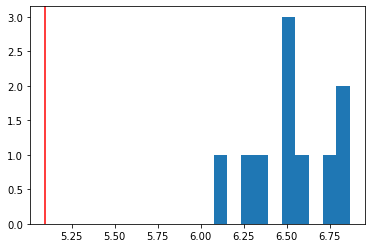

In [29]:
plt.hist(perm['shared'])
plt.axvline(observed['shared'], color='r')

In [131]:
clust_thresh = 0.05

ref_dist = _dist.loc[_dist.columns.str.startswith('ref_'), _dist.columns.str.startswith('ref_')].rename(index=lambda s: s[4:]).rename(columns=lambda s: s[4:])
fit_dist = _dist.loc[_dist.columns.str.startswith('fit_'), _dist.columns.str.startswith('fit_')].rename(index=lambda s: s[4:]).rename(columns=lambda s: s[4:])
ref_clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=clust_thresh, n_clusters=None, affinity='precomputed', linkage='complete'
    ).fit_predict(ref_dist),
    index=ref_dist.columns,
)
fit_clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=clust_thresh, n_clusters=None, affinity='precomputed', linkage='complete'
    ).fit_predict(fit_dist),
    index=fit_dist.columns.astype(int),
)

ref_clust.value_counts()

8      76
64     68
12     58
52     42
46     42
       ..
120     1
119     1
118     1
117     1
193     1
Length: 194, dtype: int64

In [132]:
fit_clust.value_counts().sort_values(ascending=False).head()

0     2
2     2
15    1
26    1
3     1
dtype: int64

In [133]:
ref_dedup = sf.Genotypes(ref.to_series().unstack('strain').groupby(ref_clust, axis='columns').mean().rename_axis(columns='strain').T.stack().to_xarray())
fit_dedup = sf.Genotypes(fit_genotypes.to_series().unstack('strain').groupby(fit_clust, axis='columns').mean().rename(columns=lambda x: int(x)).rename_axis(columns='strain').T.stack().to_xarray())

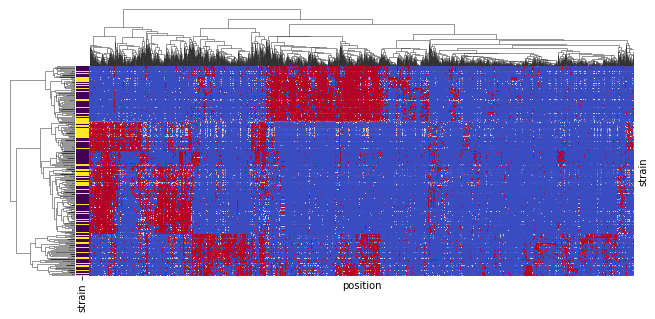

In [134]:
g = sf.data.Genotypes.concat(dict(
    ref=ref_dedup,
    fit=fit_dedup,
), dim='strain')


sf.plot.plot_genotype(g.random_sample(position=2500), row_colors_func=lambda w: w.strain.str.startswith('fit'), scaley=1e-2, scalex=3e-3, yticklabels=0)

In [151]:
g = sf.data.Genotypes.concat(dict(
    ref=ref,
    fit=fit_genotypes_filt,
), dim='strain')

all_dist = g.discretized().pdist()

In [155]:
all_clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=0.15, n_clusters=None, affinity='precomputed', linkage='average'
    ).fit_predict(all_dist),
    index=g.strain,
)

clust_stats = (
    all_clust
    .to_frame(name='clust')
    .reset_index()
    .assign(prefix=lambda x: x.strain.str[:3])
    .groupby(['clust', 'prefix'])
    .apply(len)
    .unstack(fill_value=0)
    .assign(
        tally=lambda x: x.sum(1),
        ratio=lambda x: np.log2((x.fit + 1) / (x.ref + 1))
    )
    .assign(only_fit=lambda x: x.ref==0, only_ref=lambda x: x.fit==0)
    .assign(both=lambda x: ~(x.only_fit | x.only_ref))
    .sort_values('ratio', ascending=False)
)

In [156]:
geno_clust = sf.Genotypes(g.to_series().unstack('strain').groupby(all_clust, axis='columns').mean().rename_axis(columns='strain').T.stack().to_xarray())

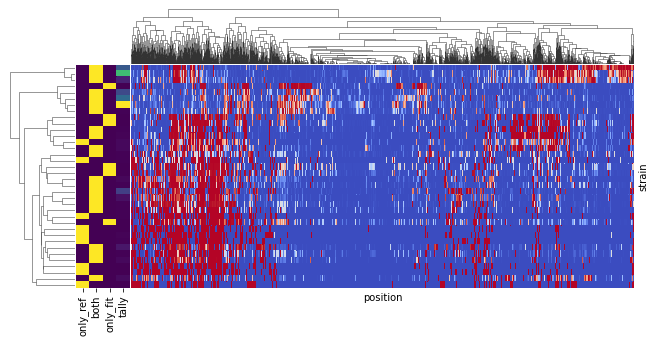

In [157]:
sf.plot.plot_genotype(geno_clust.random_sample(position=2500), row_colors_func=lambda w: clust_stats[['only_ref', 'both', 'only_fit', 'tally']].to_xarray(), scaley=1e-2, scalex=3e-3, yticklabels=0)

In [136]:
from scipy.spatial.distance import pdist, squareform

_dist3 = pd.DataFrame(squareform(pdist(g.discretized().values, metric='hamming')), index=g.strain, columns=g.strain)
_tree3 = Phylo.read(StringIO(to_newick(to_tree(linkage(squareform(_dist3), method='average')), leaf_names=_dist3.columns)), format='newick')
_tree3.root_at_midpoint()


observed, perm = tree_branch_length_fractions_permutation_test(_tree3, idxwhere(_dist3.index.to_series().str.startswith('fit_')), n=10, progress=True)

print(observed)
perm

100%|██████████| 10/10 [00:00<00:00, 18.35it/s]

total     29.686861
onlyA      8.751307
onlyB     15.552936
shared     5.382618
dtype: float64


,total,onlyA,onlyB,shared
0,29.686861,8.845436,16.892628,3.948796
1,29.686861,8.702879,16.425286,4.558696
2,29.686861,9.138172,16.298857,4.249831
3,29.686861,8.958621,16.652739,4.075501
4,29.686861,9.023716,16.485114,4.178030
5,29.686861,9.480178,15.889394,4.317288
6,29.686861,8.928072,16.720793,4.037996
7,29.686861,9.081422,16.212311,4.393127
8,29.686861,9.464714,16.038445,4.183701
9,29.686861,9.452432,16.439861,3.794568


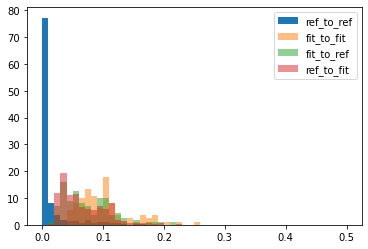

In [167]:
ref_to_ref_dist = _dist.loc[lambda x: x.index.str.startswith('ref_'), lambda x: x.index.str.startswith('ref_')]
fit_to_fit_dist = _dist.loc[lambda x: x.index.str.startswith('fit_'), lambda x: x.index.str.startswith('fit_')]

min_ref_to_ref_dist = (ref_to_ref_dist + np.eye(ref_to_ref_dist.shape[0])).min(0)
min_fit_to_fit_dist = (fit_to_fit_dist + np.eye(fit_to_fit_dist.shape[0])).min(0)

plt.hist(min_ref_to_ref_dist, bins=bins, alpha=1.0, density=True, label='ref_to_ref')
plt.hist(min_fit_to_fit_dist, bins=bins, alpha=0.5, density=True, label='fit_to_fit')
plt.hist(min_fit_to_ref_dist, bins=bins, alpha=0.5, density=True, label='fit_to_ref')
plt.hist(min_ref_to_fit_dist, bins=bins, alpha=0.5, density=True, label='ref_to_fit')
plt.legend()

In [168]:
min_ref_to_ref_dist.quantile([0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0])

0.00    0.000000
0.01    0.000000
0.05    0.000000
0.10    0.000000
0.25    0.000013
0.50    0.000119
0.75    0.008105
0.90    0.036104
0.95    0.076576
0.99    0.133126
1.00    0.223012
dtype: float64

In [169]:
min_fit_to_fit_dist.quantile([0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0])

0.00    0.042045
0.01    0.042183
0.05    0.049795
0.10    0.056837
0.25    0.070557
0.50    0.094375
0.75    0.114680
0.90    0.168036
0.95    0.180524
0.99    0.223146
1.00    0.258184
dtype: float64

In [170]:
min_fit_to_ref_dist.quantile([0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0])

0.00    0.017803
0.01    0.023325
0.05    0.027083
0.10    0.031242
0.25    0.040646
0.50    0.065557
0.75    0.100840
0.90    0.122508
0.95    0.142292
0.99    0.190108
1.00    0.216955
dtype: float64

In [171]:
min_ref_to_fit_dist.quantile([0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0])

0.00    0.017803
0.01    0.023360
0.05    0.025809
0.10    0.028473
0.25    0.034187
0.50    0.055753
0.75    0.095431
0.90    0.114149
0.95    0.135470
0.99    0.186323
1.00    0.239301
dtype: float64

(array([ 0.        ,  0.89285714,  7.14285714, 16.07142857,  8.92857143,
        12.5       ,  8.03571429,  7.14285714,  3.57142857,  9.82142857,
         9.82142857,  3.57142857,  4.46428571,  2.67857143,  0.        ,
         1.78571429,  0.        ,  0.89285714,  0.89285714,  0.89285714,
         0.        ,  0.89285714,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.

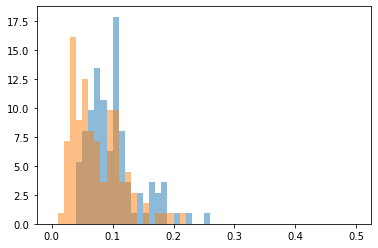

In [172]:
bins = np.linspace(0, 0.5, num=51)
plt.hist(min_fit_to_fit_dist, bins=bins, alpha=0.5, density=True)
plt.hist(min_fit_to_ref_dist, bins=bins, alpha=0.5, density=True)
# plt.hist(_dist.unstack(), bins=bins, alpha=0.5, density=True)

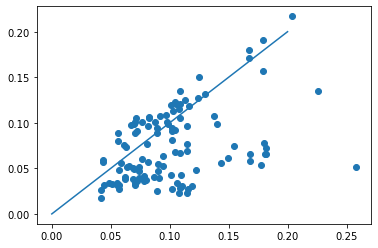

In [173]:
plt.scatter(min_fit_to_fit_dist, min_fit_to_ref_dist)
plt.plot([0, 0.2], [0, 0.2])

In [174]:
strain_coverage = (fit.communities.data * fit.metagenotypes.mean_depth()).sum("sample").to_series().rename(lambda s: f'fit_{s}')
strain_entropy = g.entropy().to_series()

/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)


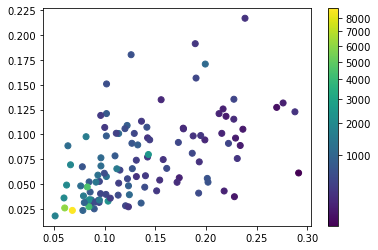

In [175]:
plt.scatter('entropy', 'min_dist', c='coverage', data=min_fit_to_ref_dist.to_frame(name='min_dist').join(strain_entropy).assign(coverage=strain_coverage), norm=mpl.colors.PowerNorm(1/2))
plt.colorbar()

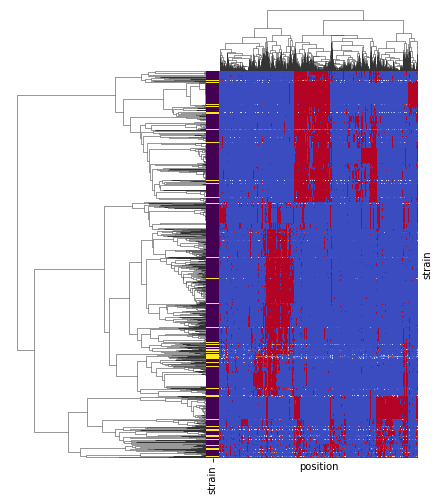

In [77]:
g = sf.data.Genotypes.concat(dict(
    ref=ref,
    fit=fit_genotypes_filt,
), dim='strain')


sf.plot.plot_genotype(
    g.random_sample(position=2500),
    row_colors_func=lambda w: w.strain.str.startswith('fit'),
    scaley=5e-3,
    scalex=1e-3,
    yticklabels=0,
    dwidth=3.0,
)

In [ ]:
sample_meta = pd.read_table('raw/shi2019s13.tsv').set_index('NCBI Accession Number')

sample_meta.groupby(['Continent', 'Country', 'Study']).apply(len)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


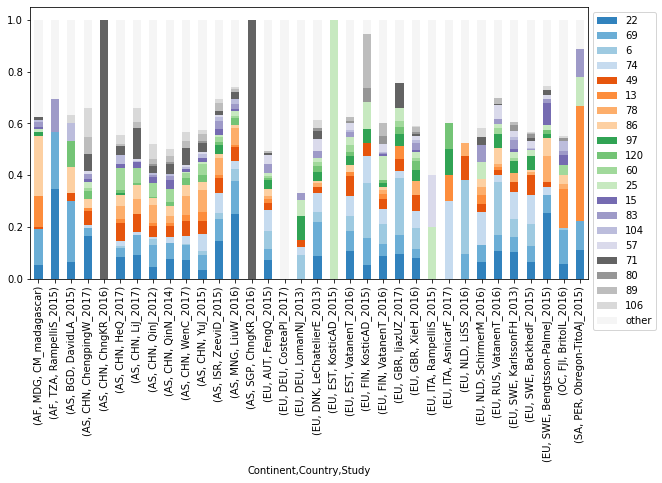

In [60]:
dominant_strain = fit.communities.data.argmax("strain").to_series()
top_strains = list(dominant_strain.value_counts().sort_values(ascending=False).head(20).index)

d = (
    dominant_strain
    .to_frame(name='strain')
    .join(sample_meta, how='inner')
    .groupby(['Continent', 'Country', 'Study', 'strain'])
    .apply(len)
    .unstack('strain', fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
    .assign(other=lambda x: 1 - x[top_strains].sum(1))
    [top_strains + ['other']]
    [sample_meta.groupby(['Continent', 'Country', 'Study']).apply(len) > 5]
)


lib.plot.construct_ordered_pallete(top_strains)

ax = (
    d
    .plot
    .bar(
        stacked=True, color=lib.plot.construct_ordered_pallete(top_strains, cm='tab20c', other='whitesmoke'),
        figsize=(10, 5)
    )
)
ax.legend(bbox_to_anchor=(1, 1))

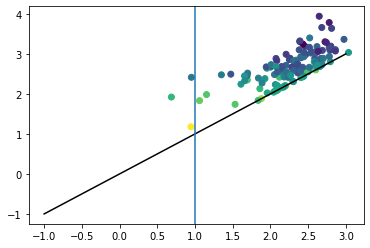

In [61]:
d = pd.DataFrame(dict(
    total=(fit.communities.data * fit.metagenotypes.mean_depth()).sum("sample"),
    maximum=(fit.communities.data * fit.metagenotypes.mean_depth()).max("sample"),
    entropy=fit.genotypes.entropy(),
), index=fit.strain)

plt.scatter('maximum', 'total', data=np.log10(d), c='entropy')
plt.plot([-1, 3], [-1, 3], color='k')
plt.axvline(1)

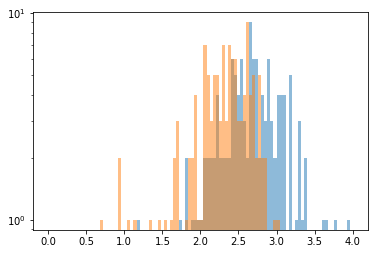

In [62]:
plt.hist((fit.communities.data * fit.metagenotypes.mean_depth()).sum("sample").to_series().apply(np.log10), bins=np.linspace(0, 4, num=101), alpha=0.5)
plt.hist((fit.communities.data * fit.metagenotypes.mean_depth()).max("sample").to_series().apply(np.log10), bins=np.linspace(0, 4, num=101), alpha=0.5)

plt.yscale('log')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


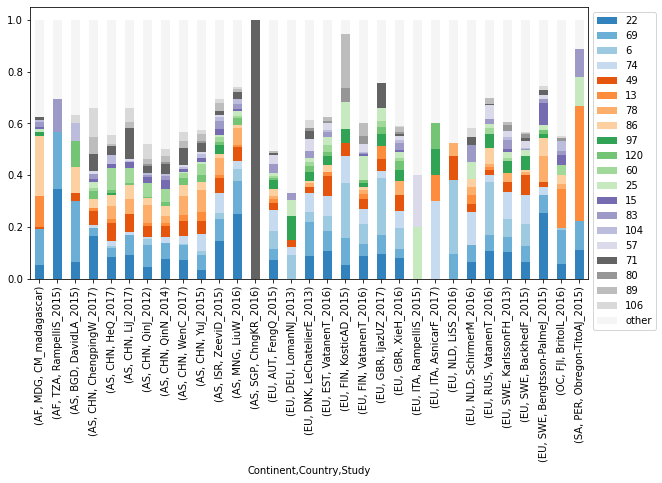

In [63]:
dominant_strain = fit.communities.data.argmax("strain").to_series()
top_strains = list(dominant_strain.value_counts().sort_values(ascending=False).head(20).index)

d0 = (
    dominant_strain
    .to_frame(name='strain')
    .join(sample_meta, how='inner')
    .groupby(['Continent', 'Country', 'Study', 'strain'])
    .apply(len)
)
    
d1 = (
    d0
    .unstack('strain', fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
    .assign(other=lambda x: 1 - x[top_strains].sum(1))
    [top_strains + ['other']]
    [(d0.groupby(['Continent', 'Country', 'Study']).sum() >= 5)]
)


lib.plot.construct_ordered_pallete(top_strains)

ax = (
    d1
    .plot
    .bar(
        stacked=True, color=lib.plot.construct_ordered_pallete(top_strains, cm='tab20c', other='whitesmoke'),
        figsize=(10, 5)
    )
)
ax.legend(bbox_to_anchor=(1, 1))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


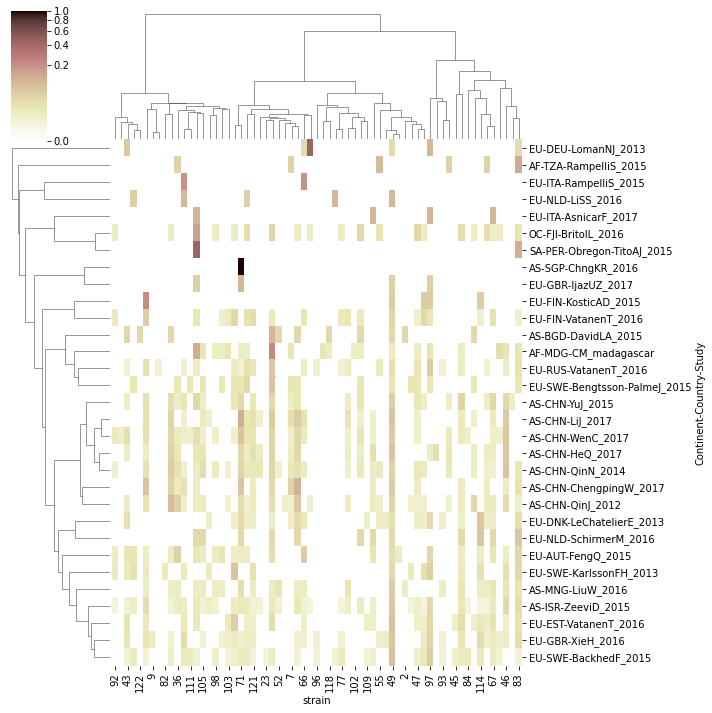

In [64]:
dominant_strain = fit.communities.data.argmax("strain").to_series()
top_strains = list(dominant_strain.value_counts().sort_values(ascending=False).head(50).index)

d0 = (
    dominant_strain
    .to_frame(name='strain')
    .join(sample_meta, how='inner')
    .groupby(['Continent', 'Country', 'Study', 'strain'])
    .apply(len)
)
    
d1 = (
    d0
    .unstack('strain', fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
#     .assign(other=lambda x: 1 - x[top_strains].sum(1))
#     [top_strains + ['other']]
    [(d0.groupby(['Continent', 'Country', 'Study']).sum() >= 5)]
    .reindex(fit.strain, axis='columns')
    .fillna(0)
)

d2 = d1.loc[d1.max(1) > 0, d1.max(0) > 0]


sns.clustermap(
    d2,
    norm=mpl.colors.PowerNorm(1/3),
    col_linkage=fit.genotypes.mlift('sel', strain=d2.columns).linkage(),
    metric='cosine',
    cmap='pink_r',
)

In [66]:
clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=0.15, n_clusters=None, affinity='precomputed', linkage='complete'
    ).fit_predict(fit.genotypes.pdist()),
    index=fit.strain,
)


agg_communities = fit.communities.to_series().unstack().groupby(clust, axis='columns').sum()

clust.value_counts()

3     26
7     16
6     15
4     14
10     9
9      5
5      4
14     4
13     3
19     3
18     3
16     3
0      3
11     3
2      3
12     2
1      2
8      2
15     1
17     1
20     1
dtype: int64

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


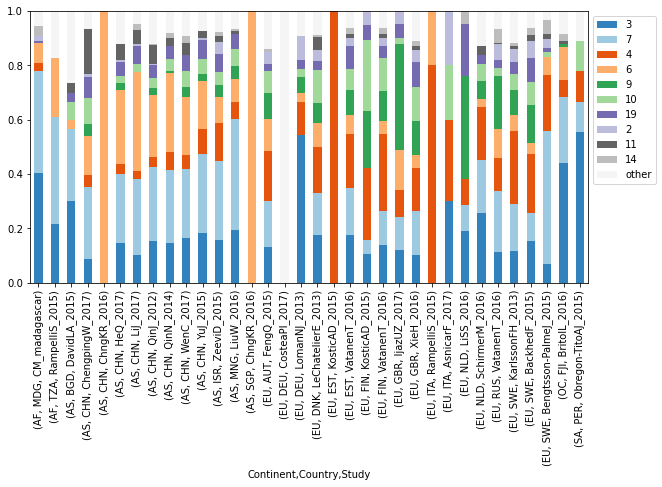

In [67]:
dominant_strain = agg_communities.idxmax(1)
top_strains = list(dominant_strain.value_counts().sort_values(ascending=False).head(10).index)

d = (
    dominant_strain
    .to_frame(name='strain')
    .join(sample_meta, how='inner')
    .groupby(['Continent', 'Country', 'Study', 'strain'])
    .apply(len)
    .unstack('strain', fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
    .assign(other=lambda x: 1 - x[top_strains].sum(1))
    [top_strains + ['other']]
    [sample_meta.groupby(['Continent', 'Country', 'Study']).apply(len) > 5]
)


lib.plot.construct_ordered_pallete(top_strains)

ax = (
    d
    .plot
    .bar(
        stacked=True, color=lib.plot.construct_ordered_pallete(top_strains, cm='tab20c', other='whitesmoke'),
        figsize=(10, 5)
    )
)
ax.legend(bbox_to_anchor=(1, 1))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


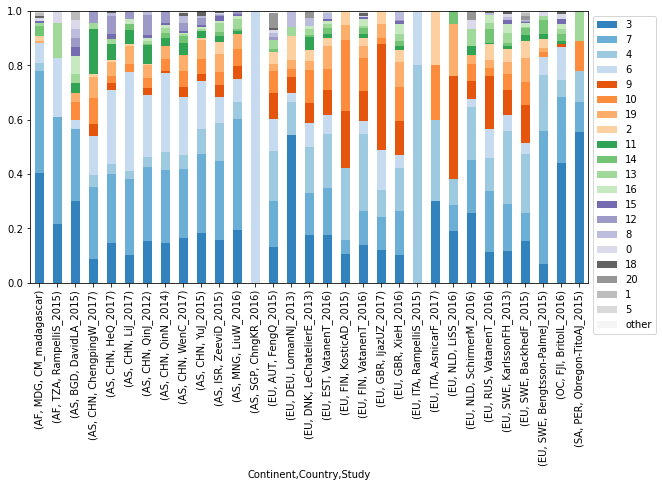

In [72]:
dominant_strain = agg_communities.idxmax(1)
top_strains = list(dominant_strain.value_counts().sort_values(ascending=False).head(20).index)

d0 = (
    dominant_strain
    .to_frame(name='strain')
    .join(sample_meta, how='inner')
    .groupby(['Continent', 'Country', 'Study', 'strain'])
    .apply(len)
)
    
d1 = (
    d0
    .unstack('strain', fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
    .assign(other=lambda x: 1 - x[top_strains].sum(1))
    [top_strains + ['other']]
    [(d0.groupby(['Continent', 'Country', 'Study']).sum() >= 5)]
)


lib.plot.construct_ordered_pallete(top_strains)

ax = (
    d1
    .plot
    .bar(
        stacked=True, color=lib.plot.construct_ordered_pallete(top_strains, cm='tab20c', other='whitesmoke'),
        figsize=(10, 5)
    )
)
ax.legend(bbox_to_anchor=(1, 1))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


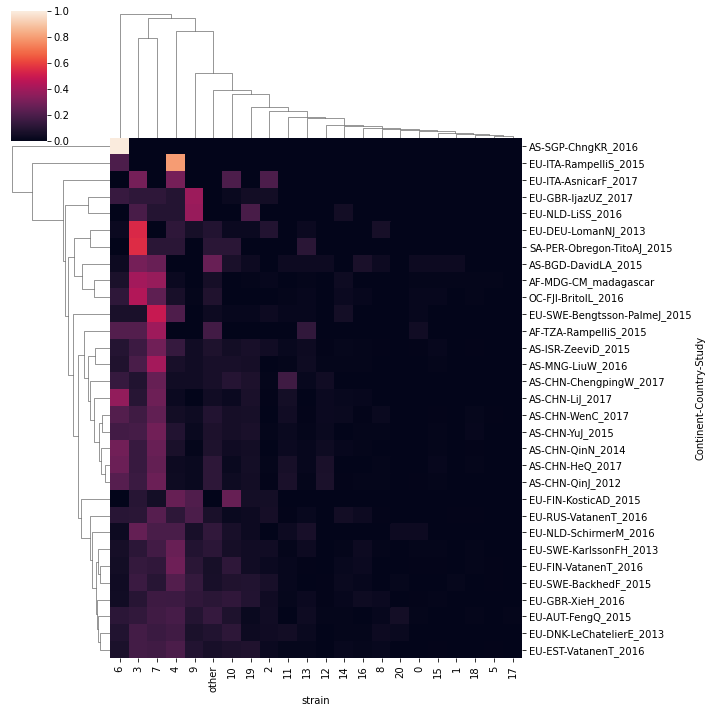

In [69]:
dominant_strain = agg_communities.idxmax(1)
top_strains = list(dominant_strain.value_counts().sort_values(ascending=False).head(10).index)

d0 = (
    dominant_strain
    .to_frame(name='strain')
    .join(sample_meta, how='inner')
    .groupby(['Continent', 'Country', 'Study', 'strain'])
    .apply(len)
)
    
d1 = (
    d0
    .unstack('strain', fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
    .assign(other=lambda x: 1 - x[top_strains].sum(1))
#     [top_strains + ['other']]
    [(d0.groupby(['Continent', 'Country', 'Study']).sum() >= 5)]
)


sns.clustermap(d1, norm=mpl.colors.PowerNorm(1/1))